# Algorytmy macierzowe

## Mnożenie macierzy IGA i FEM

In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import scipy.sparse
import time

### Konwersja macierzy n x n wygenerowanej w Octave na macierz numpy nq x nq.    
Wynikowa macierz, to macierz Octave powtórzona q razy w poziomie i pionie.

In [2]:
def input_matrix(octave_matrix, n, q=1):
    result = np.zeros((n*q, n*q))
    
    for elem in octave_matrix:
        m = re.match(r"\s*\((\d+), (\d+)\) -> (\d+\.\d+)\s*", elem)
        x, y, value = m.groups()
        for i in range(q):
            for j in range(q):
                result[i*n + int(x) - 1, j*n + int(y) - 1] = float(value)
        
    return result

In [3]:
def load_octave_matrix(filename):
    with open(filename, "r") as file:
        return file.readlines()

### Sześć algorytmów mnożenia macierzy w zależności od kolejności pętli i, j oraz p.    
A - macierz wejściowa m x k    
B - macierz wejściowa k x n    
C - macierz wynikowa m x n

In [4]:
def matrix_mul_ijp(A, B, C, m, n, k):
    for i in range(m):
        for j in range(n):
            for p in range(k):
                 C[i,j] += A[i,p]*B[p,j]
                    
def matrix_mul_ipj(A, B, C, m, n, k):
    for i in range(m):
        for p in range(k):
            for j in range(n):
                 C[i,j] += A[i,p]*B[p,j]

def matrix_mul_jip(A, B, C, m, n, k):
    for j in range(n):
        for i in range(m):
            for p in range(k):
                 C[i,j] += A[i,p]*B[p,j]

def matrix_mul_jpi(A, B, C, m, n, k):
    for j in range(n):
        for p in range(k):
            for i in range(m):
                 C[i,j] += A[i,p]*B[p,j]

def matrix_mul_pij(A, B, C, m, n, k):
    for p in range(k):
        for i in range(m):
            for j in range(n):
                 C[i,j] += A[i,p]*B[p,j]

def matrix_mul_pji(A, B, C, m, n, k):
    for p in range(k):
        for j in range(n):
            for i in range(m):
                 C[i,j] += A[i,p]*B[p,j]

### Sprawdzanie najszybszego algorytmu

In [5]:
n = 16
q = 1
N = n*q

In [6]:
IGA = load_octave_matrix("iga16x16.txt")

In [7]:
A = input_matrix(IGA, n, q)
B = input_matrix(IGA, n, q)

In [8]:
print("ijp:")
C = np.zeros((N, N))
%timeit matrix_mul_ijp(A, B, C, N, N, N)

print("ipj:")
C = np.zeros((N, N))
%timeit matrix_mul_ipj(A, B, C, N, N, N)

print("jip:")
C = np.zeros((N, N))
%timeit matrix_mul_jip(A, B, C, N, N, N)

print("jpi:")
C = np.zeros((N, N))
%timeit matrix_mul_jpi(A, B, C, N, N, N)

print("pij:")
C = np.zeros((N, N))
%timeit matrix_mul_pij(A, B, C, N, N, N)

print("pji:")
C = np.zeros((N, N))
%timeit matrix_mul_pji(A, B, C, N, N, N)

ijp:
8.99 ms ± 566 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
ipj:
8 ms ± 520 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
jip:
7.99 ms ± 465 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
jpi:
8.01 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
pij:
8.06 ms ± 76.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
pji:
9.09 ms ± 2.42 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Sprawdzanie niezerowych miejsc macierzy A, B i C

In [177]:
C = np.zeros((N, N))
matrix_mul_pji(A, B, C, N, N, N)

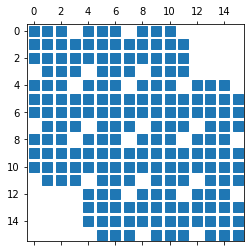

In [178]:
plt.spy(scipy.sparse.csr_matrix(A))
plt.show()

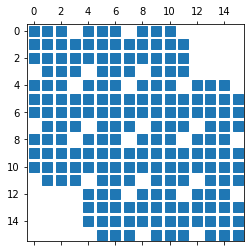

In [179]:
plt.spy(scipy.sparse.csr_matrix(B))
plt.show()

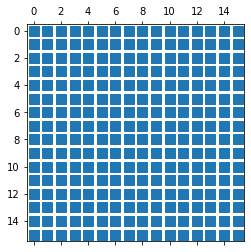

In [180]:
plt.spy(scipy.sparse.csr_matrix(C))
plt.show()

### Mnożenie blokowe macierzy przyjmując wielkość bloków: block_size x block_size.

matrix_mul_fun to jedna z wybranych funkcji mnożenia macierzy zaimplementowanych wyżej

In [148]:
def matrix_block_mul(A, B, C, m, n, k, block_size, matrix_mul_fun):
    for j in range(0, n, block_size):
        j_block = min(n - j, block_size)
        for i in range(0, m, block_size):
            i_block = min(m - i, block_size)
            for p in range(0, k, block_size):
                p_block = min(k - p, block_size)
                matrix_mul_fun(A[i:i + i_block, p:p + p_block], 
                               B[p:p + p_block, j:j + j_block], 
                               C[i:i + i_block, j:j + j_block], 
                               i_block, j_block, p_block)

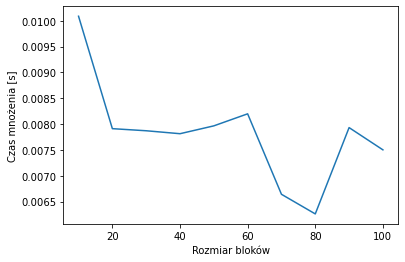

In [217]:
blocks = []
mul_time = []
multiplier = 10
runs = 100

for i in range(1, 11):
    C = np.zeros((N, N))
    t0 = time.time()
    for j in range(runs):
        matrix_block_mul(A, B, C, N, N, N, multiplier*i, matrix_mul_pji) # wstawić optymalny
    blocks.append(multiplier*i)
    mul_time.append((time.time() - t0)/100)
    
plt.plot(blocks, mul_time)
plt.xlabel("Rozmiar bloków")
plt.ylabel("Czas mnożenia [s]")
plt.show()